In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
%matplotlib inline
from datetime import datetime
import seaborn as sns

from scipy import stats

In [2]:
##We will only use the categorical features that we curate
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.greenEnergyEfficient', 'resoFacts.foundationDetails', 
                           'resoFacts.utilities', 'resoFacts.appliances', 'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.structureType', 'resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))

In [3]:
##Load the main dataframe in
##Remove the resoFacts so it's easier to look at
Month = 'September'
Year = '2022'
main_df = pd.read_csv("C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Clean_data_House_properties\\" + Month + '_' + Year + '\\houses_properties_' + Month + '.csv')
cols = main_df.columns.tolist()
for c in cols:
    if 'resoFacts.' in c:
        feature = c.split('.')[1]
        main_df[feature] = main_df[c]
        main_df.drop(labels = [c], axis = 1, inplace = True)

##Drop unimportant features 
main_df.drop(labels = ['streetAddress', 'countyId', 'hasCooling', 'hasHeating'], axis = 1, inplace = True)
main_df.reset_index(drop = True, inplace = True)
main_df

,zpid,annualHomeownersInsurance,monthlyHoaFee,livingAreaValue,bedrooms,longitude,latitude,zipcode,city,mortgageRates.fifteenYearFixedRate,...,parking,hasSpa,coveredSpaces,bathrooms,bathroomsHalf,bathroomsFull,hasFireplace,fireplaces,levels,isNewConstruction
0,220116093,756,0.0,748.0,2.0,-97.789510,33.293644,76431,Chico,5.639,...,4,False,4.0,2.0,0.0,2.0,False,0.0,One,False
1,220116230,794,0.0,1425.0,3.0,-97.798600,33.296837,76431,Chico,5.639,...,0,False,0.0,2.0,0.0,2.0,False,0.0,One,False
2,220098008,819,0.0,1416.0,2.0,-97.796005,33.292850,76431,Chico,5.639,...,2,False,2.0,2.0,0.0,2.0,False,0.0,One,False
3,78939206,622,0.0,820.0,2.0,-97.748680,33.210660,76426,Bridgeport,5.639,...,0,False,0.0,1.0,0.0,1.0,False,0.0,One,False
4,78938461,836,0.0,1296.0,4.0,-97.584170,33.239480,76234,Decatur,5.639,...,0,False,0.0,2.0,0.0,2.0,False,0.0,One,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12673,67640476,5250,0.0,4601.0,4.0,-96.857666,32.228120,76041,Forreston,5.978,...,3,False,3.0,6.0,2.0,4.0,True,1.0,Two,False
12674,117637372,8190,0.0,3659.0,4.0,-97.042015,32.297650,76064,Maypearl,5.978,...,3,True,3.0,4.0,2.0,2.0,True,2.0,One,False
12675,67656170,3776,0.0,2584.0,3.0,-96.832670,32.359640,75165,Waxahachie,5.978,...,0,False,0.0,2.0,0.0,2.0,False,0.0,One,False
12676,67640330,5670,0.0,2826.0,3.0,-96.945750,32.342957,75167,Waxahachie,5.978,...,2,False,2.0,3.0,0.0,3.0,True,1.0,One,False


In [4]:
##Load in the category data and join it with the main dataframe
path_abs = "C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Houses_categorical_property\\"
for category in Selected_features:
    ft = category.split('.')[1]
    name = 'houses' + '_' + ft + '.csv'
    df_cat = pd.read_csv(path_abs + Month + '_' + Year + '\\' + name)
    main_df = pd.merge(main_df, df_cat, how = 'left', on = 'zpid')

In [5]:
##Normalize and one-hot encoding the dataset
##If the feature only has 2 uniques value, we can mark 1 or 0 for the column
##lower case all string variables
all_cols = main_df.columns.tolist()
main_df.drop(labels = ['zpid'], axis = 1, inplace = True)
category_list = ['zipcode', 'city', 'county', 'SchoolDistrict', 'isSeniorCommunity', 'hasAssociation', 'hasPrivatePool', 
                 'canRaiseHorses', 'hasGarage', 'hasAttachedGarage', 'hasCarport', 'hasSpa', 'hasFireplace', 
                 'levels', 'isNewConstruction']

numerical_list = ['annualHomeownersInsurance', 'monthlyHoaFee', 'livingAreaValue', 'bedrooms', 'longitude', 'latitude',
                  'mortgageRates.fifteenYearFixedRate', 'mortgageRates.thirtyYearFixedRate', 'mortgageRates.arm5Rate', 
                  'propertyTaxRate', 'price', 'Crime_per_1000', 'carportSpaces', 'garageSpaces', 'parking', 'coveredSpaces',
                  'bathrooms', 'bathroomsHalf', 'bathroomsFull', 'fireplaces']



In [6]:
main_df.isnull().values.any()

False

In [7]:
columns = main_df.columns.tolist()
for col in columns:
    print("Null in "+ col + ": {}".format(main_df[col].isnull().sum()))

Null in annualHomeownersInsurance: 0
Null in monthlyHoaFee: 0
Null in livingAreaValue: 0
Null in bedrooms: 0
Null in longitude: 0
Null in latitude: 0
Null in zipcode: 0
Null in city: 0
Null in mortgageRates.fifteenYearFixedRate: 0
Null in mortgageRates.thirtyYearFixedRate: 0
Null in mortgageRates.arm5Rate: 0
Null in propertyTaxRate: 0
Null in price: 0
Null in county: 0
Null in SchoolDistrict: 0
Null in Crime_per_1000: 0
Null in isSeniorCommunity: 0
Null in hasAssociation: 0
Null in hasPrivatePool: 0
Null in canRaiseHorses: 0
Null in hasGarage: 0
Null in hasAttachedGarage: 0
Null in hasCarport: 0
Null in carportSpaces: 0
Null in garageSpaces: 0
Null in parking: 0
Null in hasSpa: 0
Null in coveredSpaces: 0
Null in bathrooms: 0
Null in bathroomsHalf: 0
Null in bathroomsFull: 0
Null in hasFireplace: 0
Null in fireplaces: 0
Null in levels: 0
Null in isNewConstruction: 0
Null in appliances_ElectricCooktop: 0
Null in appliances_ElectricOven: 0
Null in appliances_Microwave: 0
Null in appliance

### Transform the columns' values into range 0 to 1

In [8]:
##We want to concatenate data into 0 and 1 to do TSNE
##But remember to keep the label that you want to graph TSNE with

def transformed_data(main_df, category_list, numerical_list, label):
    df_train = main_df.copy()
    
    category_list = list(set(category_list) - set([label]))
    for cat in category_list:
        all_values = df_train[cat].unique()
        if (len(all_values) == 2) and (True in all_values) and (False in all_values):
            df_train.loc[df_train[cat] == True, cat] = 1
            df_train.loc[df_train[cat] == False, cat] = 0
        elif len(all_values) > 2:
            new_ft = pd.get_dummies(df_train[cat], prefix = cat)
            df_train = pd.concat([df_train, new_ft], axis = 1)
            df_train.drop(labels = [cat], axis = 1, inplace = True)

    for num in numerical_list:
        col = df_train[num].to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler()
        col_transformed = scaler.fit_transform(col)
        df_train[num] = col_transformed
    
    features = list(set(df_train.columns.tolist()) - set([label]))
    df_train = df_train[features + [label]]
    return df_train

In [9]:
label = 'county'
df_train = transformed_data(main_df, category_list, numerical_list, label)
X_train = df_train.iloc[:, :-1].to_numpy()
Y_train = df_train.iloc[:, -1].to_numpy()
n = X_train.shape[1]

In [10]:
##Here to check if the matrix transform correctly
j_min = np.zeros([n, ])
for j in range(len(j_min)):
    j_min[j] = np.min(X_train[:, j])
j_min

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### TSNE

In [11]:
tsne = TSNE(n_components = 2, random_state = 0, learning_rate = 'auto', n_iter = 1200)
projections = tsne.fit_transform(X_train)

C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [13]:
projections

array([[ 65.09502 , -39.257675],
       [ 57.588814, -46.522583],
       [ 65.30162 , -39.36092 ],
       ...,
       [ 37.686337,  20.374014],
       [  9.068072,  38.271152],
       [ 73.62784 , -47.19455 ]], dtype=float32)

In [14]:
proj_df = pd.DataFrame(data = projections, columns = ['x', 'y'])
proj_df['County'] = Y_train
proj_df

,x,y,County
0,65.095016,-39.257675,wise
1,57.588814,-46.522583,wise
2,65.301620,-39.360920,wise
3,70.723839,-43.532524,wise
4,50.253838,-48.983761,wise
...,...,...,...
12673,-7.217651,-65.834602,ellis
12674,-13.267316,-70.626358,ellis
12675,37.686337,20.374014,ellis
12676,9.068072,38.271152,ellis


In [15]:
n = len(proj_df.County.unique())
n

10

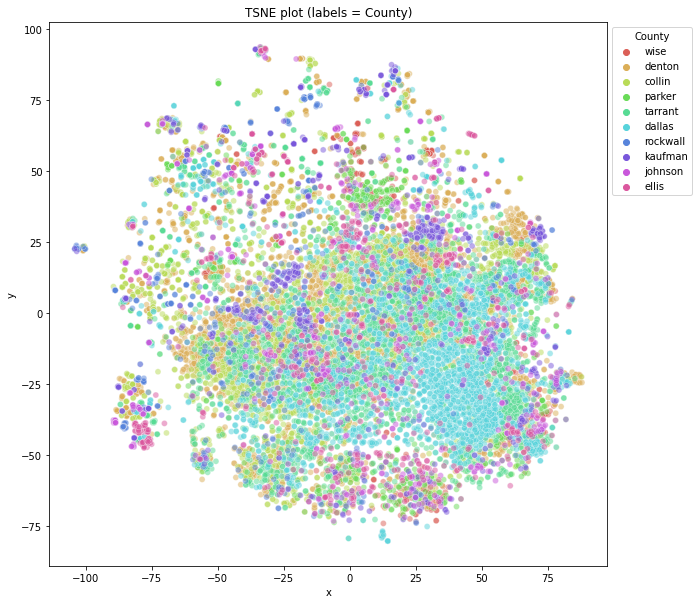

In [16]:
plt.figure(figsize = (10, 10))
ax= sns.scatterplot(x = 'x', y = 'y', hue = 'County', 
                    palette = sns.color_palette("hls", n), data = proj_df,
                    legend = 'full', alpha = 0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))
plt.title("TSNE plot (labels = County)")
plt.show()

## TSNE with price group

In [23]:
##Separate prices into groups and use TSNE on them
##Drop the price column
##Group 1: $0 - $200k (endpoint is exclusive)
##Group 2: $200k - $400k
##Group 3: $400k - $600k
##Group 4: $600k - $800k
##Group 5: > $800k
df_replicate = main_df.copy()
df_replicate['price_group'] = 0
df_replicate.loc[(df_replicate['price'] >= 0) & (df_replicate['price'] < 200000), 'price_group'] = '0 to 200k ($)'
df_replicate.loc[(df_replicate['price'] >= 200000) & (df_replicate['price'] < 400000), 'price_group'] = '200k to 400k ($)'
df_replicate.loc[(df_replicate['price'] >= 400000) & (df_replicate['price'] < 600000), 'price_group'] = '400k to 600k ($)'
df_replicate.loc[(df_replicate['price'] >= 600000) & (df_replicate['price'] < 800000), 'price_group'] = '600k to 800k ($)'
df_replicate.loc[(df_replicate['price'] >= 800000), 'price_group'] = '>= 800k ($)'
df_replicate.drop(labels = ['price'], axis = 1, inplace = True)

In [24]:
label = 'price_group'
n_list = list(set(numerical_list) - set(['price']))
df_r_transformed = transformed_data(df_replicate, category_list, n_list, label)
X_r_t = df_r_transformed.iloc[:, :-1].to_numpy()
Y_r_t = df_r_transformed.iloc[:, -1].to_numpy()

In [25]:
tsne_r_t = TSNE(n_components = 2, random_state = 0, learning_rate = 'auto', n_iter = 1200)
projections_r_t = tsne_r_t.fit_transform(X_r_t)
proj_df_r_t = pd.DataFrame(data = projections_r_t, columns = ['x', 'y'])
proj_df_r_t['price_group'] = Y_r_t
proj_df_r_t

C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


,x,y,price_group
0,76.592354,-13.706992,0 to 200k ($)
1,75.297943,-13.182339,0 to 200k ($)
2,76.823372,-13.844850,0 to 200k ($)
3,72.578674,-27.885489,0 to 200k ($)
4,81.927818,-27.653872,0 to 200k ($)
...,...,...,...
12673,-9.959495,15.929268,>= 800k ($)
12674,-23.992907,-70.289825,>= 800k ($)
12675,24.945471,17.360687,>= 800k ($)
12676,26.650866,48.372089,>= 800k ($)


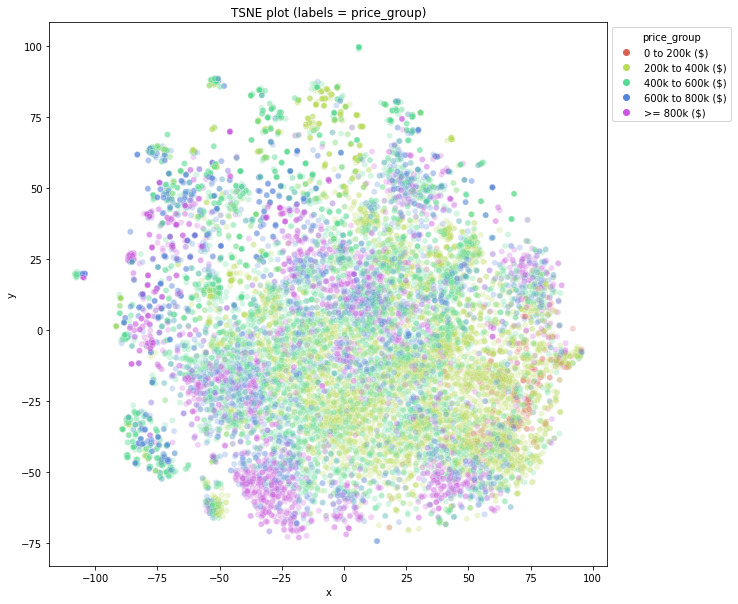

In [26]:
n = len(proj_df_r_t.price_group.unique())
plt.figure(figsize = (10, 10))
ax= sns.scatterplot(x = 'x', y = 'y', hue = 'price_group', 
                    palette = sns.color_palette("hls", n), data = proj_df_r_t,
                    legend = 'full', alpha = 0.25)
sns.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))
plt.title("TSNE plot (labels = price_group)")
plt.show()

In [27]:
###What if we increase the perplexity to 100
tsne_r_t2 = TSNE(n_components = 2, perplexity = 100, random_state = 0, learning_rate = 'auto', n_iter = 1200)
projections_r_t = tsne_r_t2.fit_transform(X_r_t)
proj_df_r_t = pd.DataFrame(data = projections_r_t, columns = ['x', 'y'])
proj_df_r_t['price_group'] = Y_r_t
proj_df_r_t

C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


,x,y,price_group
0,58.001087,-3.345683,0 to 200k ($)
1,57.524727,-3.371014,0 to 200k ($)
2,58.236469,-3.173367,0 to 200k ($)
3,55.956474,2.348915,0 to 200k ($)
4,60.620014,3.129861,0 to 200k ($)
...,...,...,...
12673,-5.755681,-19.084524,>= 800k ($)
12674,-2.699454,48.227787,>= 800k ($)
12675,30.973246,-19.203558,>= 800k ($)
12676,2.258727,-22.611097,>= 800k ($)


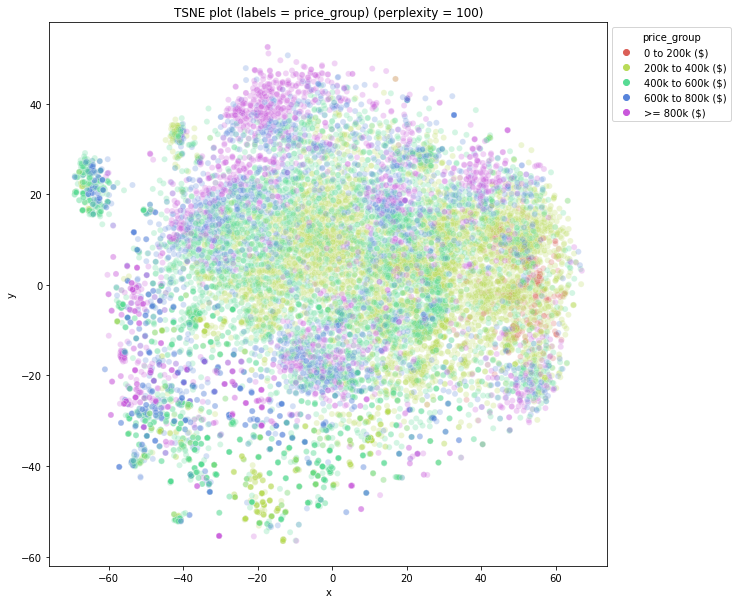

In [28]:
n = len(proj_df_r_t.price_group.unique())
plt.figure(figsize = (10, 10))
ax= sns.scatterplot(x = 'x', y = 'y', hue = 'price_group', 
                    palette = sns.color_palette("hls", n), data = proj_df_r_t,
                    legend = 'full', alpha = 0.25)
sns.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))
plt.title("TSNE plot (labels = price_group) (perplexity = 100)")
plt.show()

### Checking the price distribution between houses with private pools and without private pools

In [11]:
main_df.columns.tolist()

['annualHomeownersInsurance',
 'monthlyHoaFee',
 'livingAreaValue',
 'bedrooms',
 'longitude',
 'latitude',
 'zipcode',
 'city',
 'mortgageRates.fifteenYearFixedRate',
 'mortgageRates.thirtyYearFixedRate',
 'mortgageRates.arm5Rate',
 'propertyTaxRate',
 'price',
 'county',
 'SchoolDistrict',
 'Crime_per_1000',
 'isSeniorCommunity',
 'hasAssociation',
 'hasPrivatePool',
 'canRaiseHorses',
 'hasGarage',
 'hasAttachedGarage',
 'hasCarport',
 'carportSpaces',
 'garageSpaces',
 'parking',
 'hasSpa',
 'coveredSpaces',
 'bathrooms',
 'bathroomsHalf',
 'bathroomsFull',
 'hasFireplace',
 'fireplaces',
 'levels',
 'isNewConstruction',
 'appliances_ElectricCooktop',
 'appliances_ElectricOven',
 'appliances_Microwave',
 'appliances_ElectricRange',
 'appliances_Refrigerator',
 'appliances_GasRange',
 'appliances_GasOven',
 'appliances_GasWaterHeater',
 'appliances_Dishwasher',
 'appliances_Disposal',
 'appliances_VentedExhaustFan',
 'appliances_ElectricWaterHeater',
 'appliances_TanklessWaterHeater

In [12]:
prices_pool = main_df.loc[main_df['hasPrivatePool'] == True]
prices_nopool = main_df.loc[main_df['hasPrivatePool'] == False]

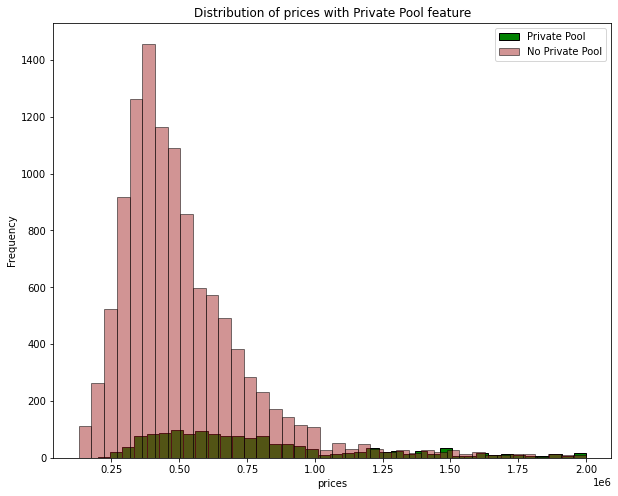

In [31]:
plt.figure(figsize = (10, 8))
plt.hist(prices_pool['price'], bins = 40, alpha = 1, color = 'green', edgecolor = 'k', label = 'Private Pool')
plt.hist(prices_nopool['price'], bins = 40, alpha = 0.5, color = 'brown', edgecolor = 'k', label = 'No Private Pool')
plt.title("Distribution of prices with Private Pool feature")
plt.xlabel("prices")
plt.ylabel("Frequency")
plt.legend(loc = 'upper right')
plt.show()

#### Prices distribution with Spa

In [18]:
prices_spa = main_df.loc[main_df['hasSpa'] == True]
prices_nospa = main_df.loc[main_df['hasSpa'] == False]

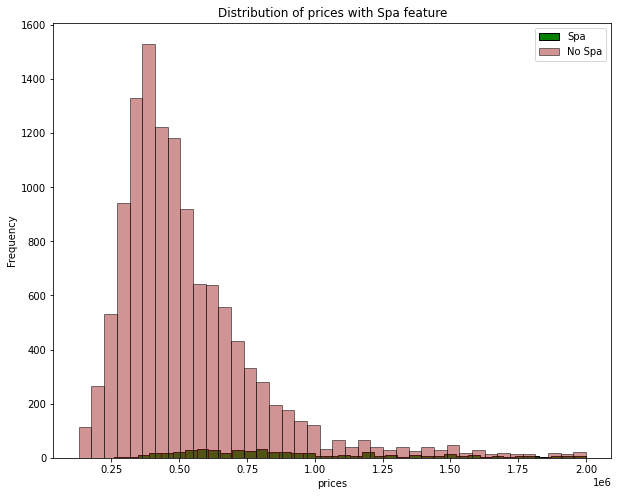

In [33]:
plt.figure(figsize = (10, 8))
plt.hist(prices_spa['price'], bins = 40, alpha = 1, color = 'green', edgecolor = 'k', label = 'Spa')
plt.hist(prices_nospa['price'], bins = 40, alpha = 0.5, color = 'brown', edgecolor = 'k', label = 'No Spa')
plt.title("Distribution of prices with Spa feature")
plt.xlabel("prices")
plt.ylabel("Frequency")
plt.legend(loc = 'upper right')
plt.show()

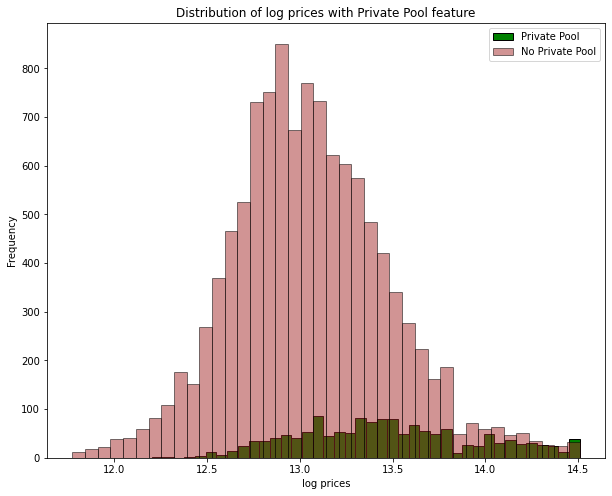

In [34]:
##What if we do log price
plt.figure(figsize = (10, 8))
plt.hist(np.log(prices_pool['price']), bins = 40, alpha = 1, color = 'green', edgecolor = 'k', label = 'Private Pool')
plt.hist(np.log(prices_nopool['price']), bins = 40, alpha = 0.5, color = 'brown', edgecolor = 'k', label = 'No Private Pool')
plt.title("Distribution of log prices with Private Pool feature")
plt.xlabel("log prices")
plt.ylabel("Frequency")
plt.legend(loc = 'upper right')
plt.show()

In [8]:
main_df

,annualHomeownersInsurance,monthlyHoaFee,livingAreaValue,bedrooms,longitude,latitude,zipcode,city,mortgageRates.fifteenYearFixedRate,mortgageRates.thirtyYearFixedRate,...,heating_Central,heating_NaturalGas,heating_Other,heating_ENERGYSTARQualifiedEquipment,heating_Fireplace(s),heating_HeatPump,heating_Zoned,structureType_Single Detached,structureType_None,structureType_Other
0,756,0.0,748.0,2.0,-97.789510,33.293644,76431,Chico,5.639,6.470,...,0,0,0,0,0,0,0,0,0,1
1,794,0.0,1425.0,3.0,-97.798600,33.296837,76431,Chico,5.639,6.470,...,1,0,0,0,0,0,0,1,0,0
2,819,0.0,1416.0,2.0,-97.796005,33.292850,76431,Chico,5.639,6.470,...,1,1,0,0,0,0,0,1,0,0
3,622,0.0,820.0,2.0,-97.748680,33.210660,76426,Bridgeport,5.639,6.470,...,0,0,1,0,0,0,0,1,0,0
4,836,0.0,1296.0,4.0,-97.584170,33.239480,76234,Decatur,5.639,6.470,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12673,5250,0.0,4601.0,4.0,-96.857666,32.228120,76041,Forreston,5.978,6.143,...,1,0,0,0,1,0,0,1,0,0
12674,8190,0.0,3659.0,4.0,-97.042015,32.297650,76064,Maypearl,5.978,6.143,...,1,0,0,0,1,0,0,1,0,1
12675,3776,0.0,2584.0,3.0,-96.832670,32.359640,75165,Waxahachie,5.978,6.143,...,0,0,0,0,0,0,0,1,0,0
12676,5670,0.0,2826.0,3.0,-96.945750,32.342957,75167,Waxahachie,5.978,6.143,...,0,0,1,0,1,1,0,1,0,0


In [15]:
##Do statistical test for pool and no pool
##This function will compare the distribution of prices based on binary categorical features
def compare_table(df1, df2, label):
    u1 = np.round(np.mean(df1['price']), 2)
    u2 = np.round(np.mean(df2['price']), 2)
    mean_array = np.array([[u1, u2]])
    
    std1 = np.round(np.std(df1['price']), 2)
    std2 = np.round(np.std(df2['price']), 2)
    std_array = np.array([[std1, std2]])
    
    median1 = np.round(np.median(df1['price']), 2)
    median2 = np.round(np.median(df2['price']), 2)
    median_array = np.array([[median1, median2]])
    
    mode1 = np.round(stats.mode(df1['price'])[0][0], 2)
    mode2 = np.round(stats.mode(df2['price'])[0][0], 2)
    mode_array = np.array([[mode1, mode2]])
    
    skew1 = np.round(stats.skew(df1['price']), 2)
    skew2 = np.round(stats.skew(df2['price']), 2)
    skew_array = np.array([[skew1, skew2]])
    
    kurtosis1 = np.round(stats.kurtosis(df1['price'], fisher = False), 2)
    kurtosis2 = np.round(stats.kurtosis(df2['price'], fisher = False), 2)
    kurtosis_array = np.array([[kurtosis1, kurtosis2]])
    
    statistics = np.concatenate((mean_array, std_array, median_array, mode_array, skew_array, kurtosis_array), axis = 0)
    df_stat = pd.DataFrame(statistics, columns = [label, 'no_' + label])
    df_temp = pd.DataFrame(pd.Series(['mean', 'std', 'median', 'mode', 'skewness', 'kurtosis']), columns = ['Statistics'])
    df_stat = pd.concat([df_temp, df_stat], axis = 1)
    df_stat.set_index(['Statistics'], inplace = True)
    return df_stat

In [17]:
pool_comparison = compare_table(prices_pool, prices_nopool, label = 'pool')
pool_comparison

,pool,no_pool
Statistics,,
mean,799776.69,514779.02
std,407670.40,253440.13
median,685000.00,450000.00
mode,599000.00,350000.00
skewness,1.11,2.11
kurtosis,3.54,9.61


In [19]:
spa_comparison = compare_table(prices_spa, prices_nospa, label = 'spa')
spa_comparison

,spa,no_spa
Statistics,,
mean,930142.14,531804.80
std,421605.89,272182.47
median,800000.00,465000.00
mode,599000.00,350000.00
skewness,0.80,2.09
kurtosis,2.70,9.04


In [23]:
stats.skew(prices_pool['price'])

1.114103530935632

In [20]:
stats.mode(prices_nopool['price'])

ModeResult(mode=array([350000], dtype=int64), count=array([110]))

In [26]:
##One hot encoding apply to all categorical features
def transformed_data2(main_df, category_list, numerical_list):
    df_train = main_df.copy()
    
    category_list = list(set(category_list))
    for cat in category_list:
        all_values = df_train[cat].unique()
        if (len(all_values) == 2) and (True in all_values) and (False in all_values):
            df_train.loc[df_train[cat] == True, cat] = 1
            df_train.loc[df_train[cat] == False, cat] = 0
        elif len(all_values) > 2:
            new_ft = pd.get_dummies(df_train[cat], prefix = cat)
            df_train = pd.concat([df_train, new_ft], axis = 1)
            df_train.drop(labels = [cat], axis = 1, inplace = True)

    for num in numerical_list:
        col = df_train[num].to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler()
        col_transformed = scaler.fit_transform(col)
        df_train[num] = col_transformed
    
    features = list(set(df_train.columns.tolist()))
    df_train = df_train[features + ['price']]
    return df_train

In [27]:
n_list = list(set(numerical_list) - set(['price']))
df_encoded = transformed_data2(main_df, category_list, n_list)

In [28]:
df_encoded

,zipcode_75040,securityFeatures_Burglar,zipcode_76058,city_Fort Worth,zipcode_75156,zipcode_76205,zipcode_76104,Crime_per_1000,zipcode_76134,city_Little Elm,...,SchoolDistrict_Midlothian ISD,zipcode_75056,poolFeatures_InGround,city_Fort worth,sewer_Septic,zipcode_76065,fireplaceFeatures_Decorative,city_Chico,greenEnergyEfficient_WaterHeater,price
0,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,179900
1,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,189000
2,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,195000
3,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,148000
4,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,199000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12673,0,0,0,0,0,0,0,0.234657,0,0,...,0,0,1,0,0,0,0,0,0,1250000
12674,0,0,0,0,0,0,0,0.234657,0,0,...,0,0,1,0,0,0,1,0,0,1950000
12675,0,0,0,0,0,0,0,0.234657,0,0,...,0,0,0,0,1,0,0,0,0,899000
12676,0,0,0,0,0,0,0,0.234657,0,0,...,0,0,0,0,0,0,0,0,0,1350000


In [30]:
main_df.columns.tolist()

['annualHomeownersInsurance',
 'monthlyHoaFee',
 'livingAreaValue',
 'bedrooms',
 'longitude',
 'latitude',
 'zipcode',
 'city',
 'mortgageRates.fifteenYearFixedRate',
 'mortgageRates.thirtyYearFixedRate',
 'mortgageRates.arm5Rate',
 'propertyTaxRate',
 'price',
 'county',
 'SchoolDistrict',
 'Crime_per_1000',
 'isSeniorCommunity',
 'hasAssociation',
 'hasPrivatePool',
 'canRaiseHorses',
 'hasGarage',
 'hasAttachedGarage',
 'hasCarport',
 'carportSpaces',
 'garageSpaces',
 'parking',
 'hasSpa',
 'coveredSpaces',
 'bathrooms',
 'bathroomsHalf',
 'bathroomsFull',
 'hasFireplace',
 'fireplaces',
 'levels',
 'isNewConstruction',
 'appliances_ElectricCooktop',
 'appliances_ElectricOven',
 'appliances_Microwave',
 'appliances_ElectricRange',
 'appliances_Refrigerator',
 'appliances_GasRange',
 'appliances_GasOven',
 'appliances_GasWaterHeater',
 'appliances_Dishwasher',
 'appliances_Disposal',
 'appliances_VentedExhaustFan',
 'appliances_ElectricWaterHeater',
 'appliances_TanklessWaterHeater

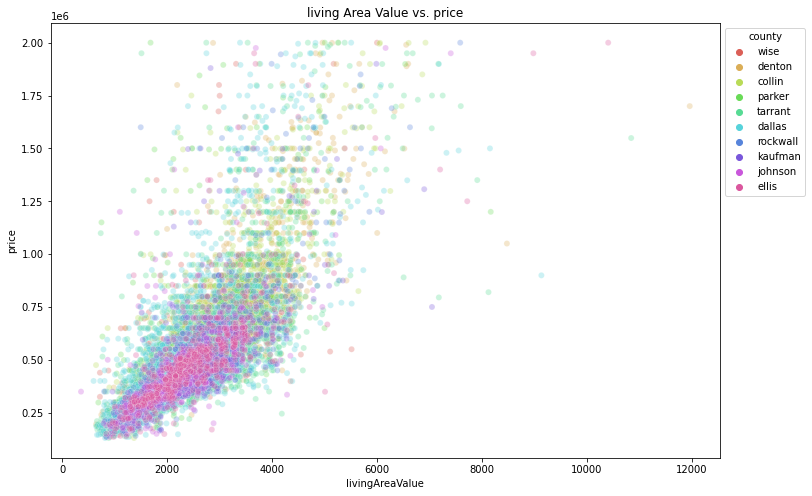

In [37]:
n = len(main_df.county.unique())
plt.figure(figsize = (12, 8))
ax= sns.scatterplot(x = 'livingAreaValue', y = 'price', hue = 'county', 
                    palette = sns.color_palette("hls", n), data = main_df[['livingAreaValue', 'price', 'county']],
                    legend = 'full', alpha = 0.3)
sns.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))
plt.title("living Area Value vs. price")
plt.show()

In [ ]:
##Build something to detect fancy houses based on features.
##Models for expensive houses, and models for not expensive houses
##Build a classifier that classifies houses based on price and living area value
##expensive vs normal. (Spectral learning, K_means clustering)
##patterns in the data. (factorization)
##December 14, 2022.  

##Be able to indetify changes in global markets
##indentify the beginning of the changes, find the indicators before the changes.
##are there buyers preference for houses prices? current buyers trend,...